# Dependencies & Utilities

In [1]:
import $cp.`/workspaces/learn-scala/hello/target/scala-2.13/classes`
import $ivy.`org.locationtech.geotrellis::geotrellis-raster:3.8.0`

import $cp.$
import $ivy.$

In [2]:
import java.nio.file.{Files, Paths}
import java.util.Base64
import almond.display._

def showPng(path: String, maxWidthPx: Int = 900): Html = {
  val bytes = Files.readAllBytes(Paths.get(path))
  val b64 = Base64.getEncoder.encodeToString(bytes)
  Html(s"""<img src="data:image/png;base64,$b64" style="max-width:${maxWidthPx}px;height:auto;" />""")
}

// showPng("/workspaces/learn-scala/visualizations/everest.png", maxWidthPx = 800)

import java.nio.file.{Files, Paths}
import java.util.Base64
import almond.display._
defined function showPng

In [3]:
import geotrellis.raster._
import almond.display._
import java.util.Base64

def showTile(
  tile: Tile,
  ramp: render.ColorRamp = ColorRamps.Viridis,
  breaks: Int = 256,
  noDataColor: Int = 0x00000000,   // transparent
  maxWidthPx: Int = 900
): Html = {
  val hist = tile.histogramDouble(breaks)
  val cm = ColorMap.fromQuantileBreaks(hist, ramp, ColorMap.Options(noDataColor = noDataColor))

  val pngBytes = tile.renderPng(cm).bytes
  val b64 = Base64.getEncoder.encodeToString(pngBytes)

  Html(s"""<img src="data:image/png;base64,$b64" style="max-width:${maxWidthPx}px;height:auto;" />""")
}


import geotrellis.raster._
import almond.display._
import java.util.Base64
defined function showTile

---

# Local GeoTrellis Interactive Analysis
Was used in conjunction with `Ex05.scala` for exploring GeoTrellis raster capabilities.

In [4]:
import learningscala._
import geotrellis.raster._
import geotrellis.proj4.util.UTM
import geotrellis.raster.io.geotiff._
import geotrellis.proj4._
import geotrellis.raster.reproject._
// For GeoTrellis logging
import org.slf4j.{Logger, LoggerFactory}

import hello._
import geotrellis.raster._
import geotrellis.proj4.util.UTM
import geotrellis.raster.io.geotiff._
import geotrellis.proj4._
import geotrellis.raster.reproject._
import org.slf4j.{Logger, LoggerFactory}

In [5]:
val RESAMPLING_METHOD = ResampleMethods.Bilinear

RESAMPLING_METHOD: resample.Bilinear.type = Bilinear

In [6]:
val everestTiff = SinglebandGeoTiff(
      "./data/Everest_COP30.tif"
    )

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


everestTiff: SinglebandGeoTiff = SinglebandGeoTiff(
  tile = GeoTiffTile(301,266,float32raw),
  extent = Extent(
    xmin = 86.89930554444445,
    ymin = 27.957916677777774,
    xmax = 86.98291665555556,
    ymax = 28.031805566666662
  ),
  crs = EPSG:4326,
  tags = Tags(
    headTags = Map("AREA_OR_POINT" -> "POINT"),
    bandTags = List(Map())
  ),
  options = GeoTiffOptions(
    storageMethod = Tiled(blockCols = 256, blockRows = 256),
    compression = DeflateCompression(level = -1),
    colorSpace = 1,
    colorMap = None,
    interleaveMethod = PixelInterleave,
    subfileType = None,
    tiffType = Tiff
  ),
  overviews = List()
)

In [7]:
val utmCrs: CRS = UTM.getZoneCrs(
      lon = everestTiff.extent.center.getX(), // X is always the HORIZONTAL axis of the CRS
      lat = everestTiff.extent.center.getY() // Y is always the VERTICAL axis of the CRS
    )
  
val everest = everestTiff.projectedRaster.reproject(
      utmCrs,
      Reproject.Options.methodToOptions(RESAMPLING_METHOD)
    )

utmCrs: CRS = EPSG:32645
everest: ProjectedRaster[Tile] = ProjectedRaster(
  raster = Raster(
    tile = FloatRawArrayTile(
      arr = Array(
        6176.2305F,
        6204.6426F,
        6242.4395F,
        6277.4507F,
        6310.6396F,
        6343.4185F,
        6378.889F,
        6413.104F,
        6440.6724F,
        6472.189F,
        6511.367F,
        6557.585F,
        6605.347F,
        6656.2534F,
        6712.0186F,
        6763.5547F,
        6818.7524F,
        6863.151F,
        6906.7437F,
        6936.0356F,
        6958.487F,
        6978.333F,
        6995.616F,
        7007.124F,
        7015.7344F,
        7020.4277F,
        7030.3877F,
        7039.9707F,
        7045.6694F,
        7046.6875F,
        7045.9365F,
        7038.8457F,
        7027.5103F,
        7013.983F,
        6999.369F,
...


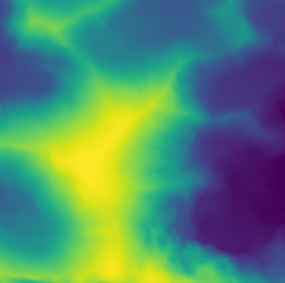

In [8]:
showTile(everest.tile)

In [ ]:
import geotrellis.raster._
import geotrellis.raster.{isData, isNoData}
import geotrellis.raster.io.geotiff._
import geotrellis.proj4._
import geotrellis.raster.reproject._
import geotrellis.proj4.util.UTM
import geotrellis.raster.histogram._
import geotrellis.raster.mapalgebra.focal.Slope
import geotrellis.raster.regiongroup.RegionGroupOptions
val log: Logger = LoggerFactory.getLogger(getClass())

// NOTE: I use `GeoTiff.mapTile` / `ProjectedRaster.mapTile` / `GeoTiff.copy(tile = ...)`
// to avoid accessing deeply nested geotrellis objects properties each time I want to do some operation
val slopes = everest.mapTile(t => t.slope(everest.cellSize))
// visualizeTile(everest, "./visualizations/everest")
// visualizeTile(slopes, "./visualizations/slopes")

/* Compute all slope based islands which are at least 70% visible from the highest point in mount everest
  * - Local, focal, zonal & global operations:
  * - Focal: slopes
  * - Iterative-Focal-Propagation: viewshed (ray wavefront expansion, resembling Dijkstra wavefront but with max slope accumulation as cost metric)
  * - Zonal: regionGroup island creation, viewshed aggregation
  * - Local: merging viewshed with islands, filtering islands
  * - Global: reporting and debugging
  */
val MAX_SLOPE: Double = 15.0
val MIN_VISIBILITY_PERCENTAGE: Double = 70
val CONNECTIVITY_METHOD: Connectivity = FourNeighbors

log.info("Computing slopeRegions...")
val slopeRegions = slopes.mapTile(t =>
  t.mapDouble(x => if (isNoData(x) || x > MAX_SLOPE) Double.NaN else 1)
    .regionGroup(RegionGroupOptions(CONNECTIVITY_METHOD))
    .tile
)

log.info("Getting DTM max height index...")
val (maxCol, maxRow, maxZ) = {
  // NOTE: GeoTrellis does not provide functional fold operation over tiles
  var (maxCol, maxRow, maxZ) = (0, 0, 0.0)
  everest.tile.foreachDouble { (col: Int, row: Int, z: Double) =>
    if (z > maxZ) {
      maxCol = col
      maxRow = row
      maxZ = z
    }
  }
  (maxCol, maxRow, maxZ)
}
log.info(s"DTM max index: maxCol=${maxCol} maxRow=${maxRow} maxZ=${maxZ})")

log.info("Computing DTM viewshed...")
val viewshed = everest.mapTile(t => t.viewshed(maxCol, maxRow, exact = false))

val viewshedRegions = viewshed.mapTile(t=>t.zonalPercentage(slopeRegions))


2 deprecations (since 2.1.1); re-run enabling -deprecation for details, or try -help


import geotrellis.raster._
import geotrellis.raster.{isData, isNoData}
import geotrellis.raster.io.geotiff._
import geotrellis.proj4._
import geotrellis.raster.reproject._
import geotrellis.proj4.util.UTM
import geotrellis.raster.histogram._
import geotrellis.raster.mapalgebra.focal.Slope
import geotrellis.raster.regiongroup.RegionGroupOptions
log: Logger = org.slf4j.helpers.NOPLogger(NOP)
slopes: ProjectedRaster[Tile] = ProjectedRaster(
  raster = Raster(
    tile = DoubleConstantNoDataArrayTile(
      arr = Array(
        18.20353548925396,
        42.84369364960893,
        44.33372619466871,
        42.47813790828026,
        42.3612036003257,
        43.042924262821444,
        43.57270718484658,
        41.53664647111629,
        40.288717920823956,
        44.387907076083685,
        48.95419434867901,
        51.37409235277495,
        52.491823644196096,
        53.79684633565929,
        54.320112940684595,
        55.337703068793196,
        54.24184402453528,
        49.620

In [13]:
showTile(viewshed.tile) // "object tile is not a member of package geotrellis.raster.viewshed" WHAT?

cmd13.sc:1: object tile is not a member of package geotrellis.raster.viewshed
val res13 = showTile(viewshed.tile)
                              ^
Compilation Failed


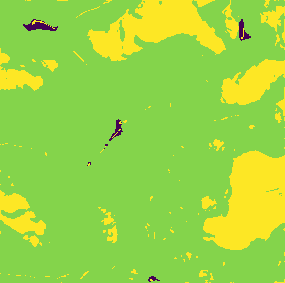

In [10]:
showTile(viewshedRegions.tile)

In [13]:
viewshed // "package geotrellis.raster.viewshed is not a value" WHAT?!

cmd13.sc:1: package geotrellis.raster.viewshed is not a value
val res13 = viewshed
            ^
Compilation Failed

In [13]:
viewshed.tile.zonalHistogramDouble(slopeRegions) // "object tile is not a member of package geotrellis.raster.viewshed" WHY?!

cmd13.sc:1: object tile is not a member of package geotrellis.raster.viewshed
val res13 = viewshed.tile.zonalHistogramDouble(slopeRegions)
                     ^
Compilation Failed